In [122]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import torch.utils.data as data
import torch
from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset

import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator #PygNodePropPredDatase

from IPython.display import clear_output

In [123]:
path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
df_edges_init = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [124]:
# Specify the path to your pickle file
pickle_file_path = 'C:\\Users\\gsamp\\OneDrive\\Documents\\AI-3\\2n Semestre\\Projecte de Síntesi 2\\GraphAnomaly\\elipticData_graph.pkl'

# Open the pickle file in binary mode
with open(pickle_file_path, 'rb') as f:
    # Load the data from the pickle file
    G = pkl.load(f)


In [125]:
df_merged = pd.merge(left=df_features, right=df_classes, on="txId", how="left")
df_merged = df_merged.set_index('txId')

class_mapping = {'unknown': 2, '1':0, '2':1}
df_merged['class'] = df_merged['class'].replace(class_mapping)
df_merged = df_merged.reset_index()
#######BALANCED#######
idxs = df_merged.loc[df_merged['class'] == 1]['txId'].sample(4500)
df_merged = df_merged.loc[(df_merged['txId'].isin(idxs))|(df_merged['class'] == 0)]
#######BALANCED#######


df_merged = df_merged.loc[df_merged['class'].isin([0,1])]
df_merged = df_merged.reset_index(drop=True)

print(df_edges_init.shape)
df_edges = df_edges_init.loc[((df_edges_init['txId1'].isin(df_merged['txId'])) & (df_edges_init['txId2'].isin(df_merged['txId'])))]
df_edges = df_edges.reset_index(drop=True)
print(df_edges.shape)

C:\Users\gsamp\AppData\Local\Temp\ipykernel_8404\4149524592.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged['class'] = df_merged['class'].replace(class_mapping)


(234355, 2)
(1558, 2)


In [126]:
#aquest mapping es farà servir per saber de quin node es tracta i poder mirar si hia ha
#errors a l'hora de generar edges i tot això
mapping_txid = dict(zip(df_merged['txId'], list(df_merged.index)))

In [127]:
m = True
if m:
    df_edges_mapped = df_edges.replace({'txId1': mapping_txid, 'txId2': mapping_txid})
    df_edges_mapped.to_pickle('dades_guillem\mapped_edges.pkl')
else:
    df_edges_mapped = pd.read_pickle('dades_guillem\mapped_edges.pkl')

In [128]:
x = torch.tensor(df_merged.drop(columns=['class', 'Time step', 'txId']).values, dtype=torch.float)
edge_index = torch.tensor(df_edges_mapped.values, dtype=torch.long).T
y = torch.tensor(df_merged['class'].values)
time = torch.tensor(df_merged['Time step'].values)


data = Data(x=x, edge_index=edge_index, y=y, time=time)


test_size = 0.2  # 20% of the data will be in the test set

# Split data into train and test sets
train_idx, test_idx = train_test_split(range(len(y)), test_size=test_size, random_state=42)

# Create train and test masks
train_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.test_mask = test_mask

In [129]:
#no es fa servir
class GraphDataset(Dataset):
    def __init__(self, x, edge_index, y, time):
        self.x = x
        self.edge_index = edge_index
        self.y = y
        self.time = time

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'x': self.x[idx],
            'edge_index': self.edge_index[idx],
            'y': self.y[idx],
            'time': self.time[idx]
        }
    

In [130]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 8)
        self.conv3 = GCNConv(8, 16)
        self.conv4 = GCNConv(16, 8)
        self.conv5 = GCNConv(8, 4)
        self.conv6 = GCNConv(4, 2)
        num_classes = torch.unique(data.y).size(0)
        self.classifier = Linear(2, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        h = self.conv4(h, edge_index)
        h = h.tanh()
        h = self.conv5(h, edge_index)
        h = h.tanh()
        h = self.conv6(h, edge_index)
        h = h.tanh()
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(165, 4)
  (conv2): GCNConv(4, 8)
  (conv3): GCNConv(8, 16)
  (conv4): GCNConv(16, 8)
  (conv5): GCNConv(8, 4)
  (conv6): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [131]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

def test(data):
    model.eval()  # Set the model to evaluation mode.
    with torch.no_grad():  # Disable gradient computation since we are in evaluation mode.
        out, _ = model(data.x, data.edge_index)  # Perform a forward pass.
        loss = criterion(out[data.test_mask], data.y[data.test_mask])
        
        pred = out.argmax(dim=1)  # Get the predicted labels by selecting the class with the highest probability.
        # print(pred)
        max_value = torch.max(pred)

        counts = torch.bincount(pred, minlength=max_value.item() + 1)

        # # Print the counts
        # for i, count in enumerate(counts):
        #     print(f"Element {i} appears {count} times.")
        # correct = pred[data.test_mask] == data.y[data.test_mask]  # Compare predicted labels with true labels for test nodes.
        # test_acc = correct.sum().item() / data.test_mask.sum().item()  # Calculate accuracy.
    return loss

gcn = False
if gcn:
    for epoch in range(400):
        loss, h, out = train(data)
        test_loss = test(data)
        print(f'Epoch: {epoch}, Loss: {loss}, Test Loss: {test_loss}')

In [132]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels,
                 hidden_channels, out_channels,
                 n_layers=2):
        
        super(SAGE, self).__init__()
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()
        self.layers_bn = torch.nn.ModuleList()
        if n_layers == 1:
            self.layers.append(SAGEConv(in_channels, out_channels,   normalize=False))
        elif n_layers == 2:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        else:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(n_layers - 2):
            self.layers.append(SAGEConv(hidden_channels,  hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))

            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        c = 0
        for layer in self.layers:
            print(c)
            layer.reset_parameters()
            c += 1
            
    def forward(self, x, edge_index):
        if len(self.layers) > 1:
            looper = self.layers[:-1]
        else:
            looper = self.layers
        
        for i, layer in enumerate(looper):
            x = layer(x, edge_index)
            try:
                x = self.layers_bn[i](x)
            except Exception as e:
                abs(1)
            finally:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        
        if len(self.layers) > 1:
            x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=-1), torch.var(x)
    
    def inference(self, total_loader, device):
        xs = []
        var_ = []
        for batch in total_loader:
            out, var = self.forward(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            xs.append(out.cpu())
            var_.append(var.item())
        
        out_all = torch.cat(xs, dim=0)
        
        return out_all, var_

In [134]:
model = SAGE(data.x.shape[1], 256, torch.unique(data.y).size(0), n_layers=2)
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=7)
criterion = torch.nn.CrossEntropyLoss()

def train(data, epoch):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    # Calculate accuracy
    correct = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
    total = data.train_mask.sum().item()
    accuracy = correct / total
    
    
    if epoch%5 == 0:
        max_value = torch.max(pred)
        counts = torch.bincount(pred, minlength=max_value.item() + 1)
        print(f"""Nodes classified as fraud: {counts[0]}, 
              nodes classified as licit: {counts[1]}""")
        
        
    return loss, accuracy

def test(data, epoch):
    model.eval()  # Set the model to evaluation mode.
    with torch.no_grad():
        out, _ = model(data.x, data.edge_index)  # Perform a forward pass.
        loss = criterion(out[data.test_mask], data.y[data.test_mask])
        
        pred = out.argmax(dim=1)  # Get the predicted labels by selecting the class with the highest probability.
        # Calculate accuracy
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        total = data.test_mask.sum().item()
        accuracy = correct / total
    return loss, accuracy
        
    
    
train_loss_history = []
test_loss_history = []
train_acc_hist = []
test_acc_hist = []

for epoch in range(epochs):
    train_loss, train_acc = train(data, epoch)
    train_loss_history.append(train_loss.detach().numpy())
    train_acc_hist.append(train_acc)
    
    test_loss, test_acc = test(data, epoch)
    test_loss_history.append(test_loss.detach().numpy())
    test_acc_hist.append(test_acc)
    
    if epoch%5 == 0:
        print(f"""Epoch: {epoch}, 
              Training Loss: {train_loss}, Training Accuracy: {train_acc}
              Test Loss: {test_loss}, Test Accuracy: {test_acc} 
              """)#, Test Loss: {test_loss}')
    

0


1
Nodes classified as fraud: 4349, 
              nodes classified as licit: 4696
Epoch: 0, 
              Training Loss: 0.7376711964607239, Training Accuracy: 0.5218352681039248
              Test Loss: 0.6980346441268921, Test Accuracy: 0.5754560530679934 
              
Nodes classified as fraud: 3946, 
              nodes classified as licit: 5099
Epoch: 5, 
              Training Loss: 0.465229332447052, Training Accuracy: 0.8884742951907131
              Test Loss: 0.6029354929924011, Test Accuracy: 0.8778330569375346 
              
Nodes classified as fraud: 4938, 
              nodes classified as licit: 4107
Epoch: 10, 
              Training Loss: 0.25641798973083496, Training Accuracy: 0.9040906578220012
              Test Loss: 0.44128137826919556, Test Accuracy: 0.875069098949696 
              
Nodes classified as fraud: 4624, 
              nodes classified as licit: 4421
Epoch: 15, 
              Training Loss: 0.18273603916168213, Training Accuracy: 0.931315644002211

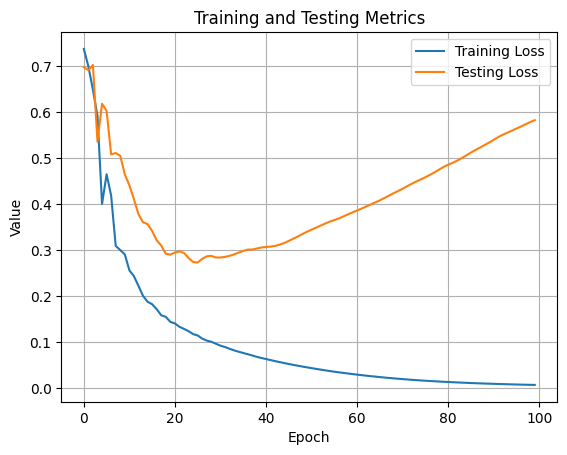

In [135]:
plt.plot([e for e in range(epochs)], train_loss_history, label='Training Loss')
plt.plot([e for e in range(epochs)], test_loss_history, label='Testing Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Testing Metrics')
plt.legend()
plt.grid(True)
plt.show()

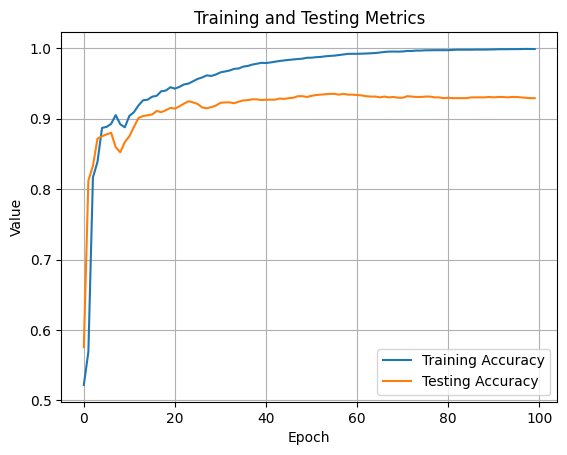

In [136]:
plt.plot([e for e in range(epochs)], train_acc_hist, label='Training Accuracy')
plt.plot([e for e in range(epochs)], test_acc_hist, label='Testing Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Testing Metrics')
plt.legend()
plt.grid(True)
plt.show()